In [1]:
#VEGAS B
#Post-Presentation Version 1
!pip install vegas
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
"""TO DO: (from prof's advice & organizational/readability improvements) COMPLETED
- fix the acceptance/rejection algorithm to correctly classify data
- separate setup from execution, specifically for VEGAS to better calculate function calls
- fix maxvalue of 1d histogram to correctly find Z boson energy
- 1st box install vegas and import modules
- 2nd box function definitions
- 3rd box function calls
"""

Defaulting to user installation because normal site-packages is not writeable


"TO DO: (from prof's advice & organizational/readability improvements)\n- fix the acceptance/rejection algorithm to correctly classify data\n- separate setup from execution, specifically for VEGAS to better calculate function calls\n- fix maxvalue of 1d histogram to correctly find Z boson energy\n- 1st box install vegas and import modules\n- 2nd box function definitions\n- 3rd box function calls\n"

In [6]:
#cnsts from first table
M_Z = 91.188  #Z bosom mass GeV
Gamma_Z = 2.4414  #Z boson width GeV
alpha_EM = 1 / 132.507  #QED coupling
sin2_theta_W = 0.222246  #Weinberg angle
G_F = 1.16639e-5  #Fermi constant GeV^-2
kappa = np.sqrt(2 * G_F * M_Z**2) * M_Z**2 / (4 * np.pi) #derived from eq.9
#cnsts from 2nd table)
Q_f = -1
V_f = -0.5 + 2 * (sin2_theta_W)
A_f = -0.5
#def A0,A1 using eq.s 8-9
def chi_1(s):
    return kappa * s / ((s - M_Z**2)**2 + Gamma_Z**2 * M_Z**2)
def chi_2(s):
    return kappa * s * Gamma_Z**2 / ((s - M_Z**2)**2 + Gamma_Z**2 * M_Z**2)
def A0(s):
    return Q_f**2 - 2 * Q_f * V_f * chi_1(s) + (V_f**2 + A_f**2) * chi_1(s) + (V_f**2 + A_f**2) * chi_2(s)
def A1(s):
    return -4 * Q_f * A_f * chi_1(s) + 8 * A_f * V_f * chi_2(s)

def differential_cross_section(ecm, cos_theta): #eq. 7
    s = ecm**2
    ds_dOmega = (alpha_EM**2 / (48 * np.pi)) * (A0(s) * (1 + cos_theta**2) + A1(s) * cos_theta)
    return ds_dOmega

#Problem A: acceptance/rejection
def find_max_cross_section(ecm_range, cos_range, grid_size=200): #fix for A/R
    ecm_min, ecm_max = ecm_range
    cos_min, cos_max = cos_range
    ecm_grid = np.linspace(ecm_min, ecm_max, grid_size)
    cos_grid = np.linspace(cos_min, cos_max, grid_size)
    max_value = 0 #init.
    #X-section peaks near Z boson mass, increase samples near 91.188GeV
    z_peak_samples = np.linspace(M_Z - 5, M_Z + 5, grid_size//2)
    ecm_grid = np.sort(np.concatenate([ecm_grid, z_peak_samples]))
    #find max over grid
    for ecm in ecm_grid: #computationally inefficient to have an exploratory phase for A/R
        for cos_theta in cos_grid:
            value = differential_cross_section(ecm, cos_theta)
            if value > max_value:
                max_value = value
    return max_value #no safety factor necessary

#event generator and A/R
def generate_drell_yan_events(num_samples, ecm_range=(10, 200), cos_range=(-1, 1)):
    ecm_min, ecm_max = ecm_range
    cos_min, cos_max = cos_range
    max_ds_value = find_max_cross_section(ecm_range, cos_range) #for correct normalization
    accepted_ecm = np.array([]) #init.
    accepted_cos = np.array([])
    total_generated = 0
    
    while len(accepted_ecm) < num_samples:
        batch_size = min(num_samples * 2, 10000)  #batches of 10,000 or fewer until done
        #batches of random samples
        ecm_samples = np.random.uniform(ecm_min, ecm_max, batch_size)
        cos_samples = np.random.uniform(cos_min, cos_max, batch_size)
        ds_values = differential_cross_section(ecm_samples, cos_samples)
        
        #generate random values and apply A/R criterion, then append
        rand_vals = np.random.uniform(0, max_ds_value, batch_size)
        mask = rand_vals < ds_values
        accepted_ecm = np.append(accepted_ecm, ecm_samples[mask])
        accepted_cos = np.append(accepted_cos, cos_samples[mask])
        total_generated += batch_size #increment
        
        #break if enough samples
        if len(accepted_ecm) >= num_samples:
            accepted_ecm = accepted_ecm[:num_samples]
            accepted_cos = accepted_cos[:num_samples]
            break
    #report acceptance rate (should be 1-5%)
    acceptance_rate = len(accepted_ecm) / total_generated
    print(f"Acceptance rate: {acceptance_rate:.4f}")

    return np.column_stack((accepted_ecm, accepted_cos))
    
#problem B: VEGAS
def generate_drell_yan_events_vegas(num_events, num_iterations, samples_per_iteration, num_bins, alpha, ecm_range=(10.0, 200.0), cos_range=(-1.0, 1.0), focus_on_z_peak=False):
    ecm_min, ecm_max = ecm_range
    cos_min, cos_max = cos_range
    
    #init. uniform grids and histograms for importance sampling
    ecm_grid = np.linspace(ecm_min, ecm_max, num_bins + 1)
    cos_grid = np.linspace(cos_min, cos_max, num_bins + 1)
    ecm_hist = np.ones(num_bins) #start with 1, not 0
    cos_hist = np.ones(num_bins)
    
    #storing events and weights
    all_events = []
    all_weights = []
    
    #grid adaptation iteration
    for iteration in range(num_iterations):
        #temporary storage
        iteration_events = []
        iteration_weights = []
        #norm hists to get pdf
        ecm_pdf = ecm_hist / np.sum(ecm_hist)
        cos_pdf = cos_hist / np.sum(cos_hist)
        
        #init. vals and variances
        f_values = np.zeros((num_bins, num_bins))
        f_squares = np.zeros((num_bins, num_bins))
        counts = np.zeros((num_bins, num_bins))
        
        #sampling
        for _ in range(samples_per_iteration):
            #select bin according to pdf (random at first)
            ecm_bin = np.random.choice(num_bins, p=ecm_pdf)
            cos_bin = np.random.choice(num_bins, p=cos_pdf)
            
            #generate points within bins, then map to physical values and find X-sect
            u_ecm = np.random.random()
            u_cos = np.random.random()
            ecm = ecm_grid[ecm_bin] + u_ecm * (ecm_grid[ecm_bin+1] - ecm_grid[ecm_bin])
            cos_theta = cos_grid[cos_bin] + u_cos * (cos_grid[cos_bin+1] - cos_grid[cos_bin])
            ds = differential_cross_section(ecm, cos_theta)
            
            #calculate jacobians, then find and store weight and record for grid adaptation
            jacobian_ecm = (ecm_grid[ecm_bin+1] - ecm_grid[ecm_bin]) * num_bins / ecm_pdf[ecm_bin]
            jacobian_cos = (cos_grid[cos_bin+1] - cos_grid[cos_bin]) * num_bins / cos_pdf[cos_bin]
            weight = ds * jacobian_ecm * jacobian_cos
            iteration_events.append((ecm, cos_theta))
            iteration_weights.append(weight)
            f_values[ecm_bin, cos_bin] += ds
            f_squares[ecm_bin, cos_bin] += ds**2 #variances
            counts[ecm_bin, cos_bin] += 1
        
        #once sampling is complete, accumulate events and weights and update grid
        all_events.extend(iteration_events)
        all_weights.extend(iteration_weights)
        # Update grid for each dimension independently
        # Avoid division by zero in empty bins
        ecm_counts = np.maximum(np.sum(counts, axis=1), 1) #do each dimension independently
        cos_counts = np.maximum(np.sum(counts, axis=0), 1)
        
        #find average values and variances within and between bins
        ecm_f = np.sum(f_values, axis=1) / ecm_counts
        cos_f = np.sum(f_values, axis=0) / cos_counts
        ecm_f2 = np.sum(f_squares, axis=1) / ecm_counts #within
        cos_f2 = np.sum(f_squares, axis=0) / cos_counts
        ecm_var = ecm_f2 - ecm_f**2 #between
        cos_var = cos_f2 - cos_f**2
        
        #if not positive, assign zero (or almost zero to avoid division problems) VERY IMPORTANT!
        ecm_var = np.maximum(ecm_var, 1e-10)
        cos_var = np.maximum(cos_var, 1e-10)
        
        #update and smooth histograms, implement filter (removed)
        ecm_hist_new = ((ecm_var * ecm_counts) / np.sum(ecm_var * ecm_counts))**alpha
        cos_hist_new = ((cos_var * cos_counts) / np.sum(cos_var * cos_counts))**alpha
        ecm_hist = 0.2 * ecm_hist + 0.8 * ecm_hist_new
        cos_hist = 0.2 * cos_hist + 0.8 * cos_hist_new
        #SavGol filter removed from this version
        #divide by zero was not a problem here
        print(f"Iteration {iteration+1}/{num_iterations} completed. Events: {len(all_events)}") #record iterations w/ print statements
    
    #convert to arrays to norm weights
    all_events = np.array(all_events)
    all_weights = np.array(all_weights)
    weights_norm = all_weights / np.sum(all_weights)
    
    #final events sampled by weights
    if len(all_events) < num_events: #debug
        print(f"Warning: Only {len(all_events)} events available, less than requested {num_events}")
        final_indices = np.arange(len(all_events))
    else:
        # Sample with replacement to ensure proper weight distribution
        final_indices = np.random.choice(
            len(all_events), 
            size=num_events, 
            replace=True,  # Allow replacement for proper weighting
            p=weights_norm
        )
    
    final_events = all_events[final_indices]
    return final_events

#visualization
def plot_distributions(events, num_bins=200): #1d histograms
    ecm_values = events[:, 0]
    cos_values = events[:, 1] 
    #create fig w/ subplot
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    #center of mass energy distribution
    ecm_hist, ecm_bin_edges = np.histogram(ecm_values, bins=num_bins)
    ecm_bin_centers = (ecm_bin_edges[:-1] + ecm_bin_edges[1:]) / 2
    #create labels
    plt.bar(ecm_bin_centers, ecm_hist, width=(ecm_bin_edges[1]-ecm_bin_edges[0]), color='blue', alpha=0.7)
    plt.xlabel('ECM [GeV]', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('ECM Distribution', fontsize=14)
    plt.grid(True, alpha=0.3) #semi-transparent grid
    
    #no SavGol necessary again
    smooth_ecm_hist = ecm_hist
    #peaks with at least 10% of max height
    peaks, _ = find_peaks(smooth_ecm_hist, height=0.1*np.max(smooth_ecm_hist), distance=10) #finds nothing
    #highest peak and corresponding phsyical value (Z boson mass)
    max_peak_index = peaks[np.argmax(smooth_ecm_hist[peaks])]
    z_boson_energy = ecm_bin_centers[max_peak_index]
    
    #dashed red line to mark z boson mass
    plt.axvline(x=z_boson_energy, color='red', linestyle='--', label=f'Z boson: {z_boson_energy:.2f} GeV')
    plt.legend(fontsize=10)
    
    #cos(theta) distribution setup and plotting
    plt.subplot(1, 2, 2)
    cos_hist, cos_bin_edges = np.histogram(cos_values, bins=num_bins)
    cos_bin_centers = (cos_bin_edges[:-1] + cos_bin_edges[1:]) / 2
    plt.bar(cos_bin_centers, cos_hist, width=(cos_bin_edges[1]-cos_bin_edges[0]), color='green', alpha=0.7)
    plt.xlabel('cos(theta)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('cos(theta) Distribution', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    #Z boson energy information
    print(f"Z Boson energy: {z_boson_energy:.3f} GeV")
    print(f"Value of highest peak: {ecm_hist[max_peak_index]}")
    print(f"Theoretical Z boson mass: 91.188 GeV")
    print(f"Difference from theoretical value: {abs(z_boson_energy - 91.188):.3f} GeV")
    return z_boson_energy

def twodplot(events): #2d histogram (heatmap)
    plt.hist2d(events[:,0], events[:,1], bins=200, cmap=plt.cm.jet)
    plt.colorbar()
    plt.title("Probability Heatmap for cos(theta) vs ECM")
    plt.xlabel("ECM (GeV)")
    plt.ylabel("cos(theta)")
    plt.show()

Acceptance rate: 0.0177
Generated 100000 total events.


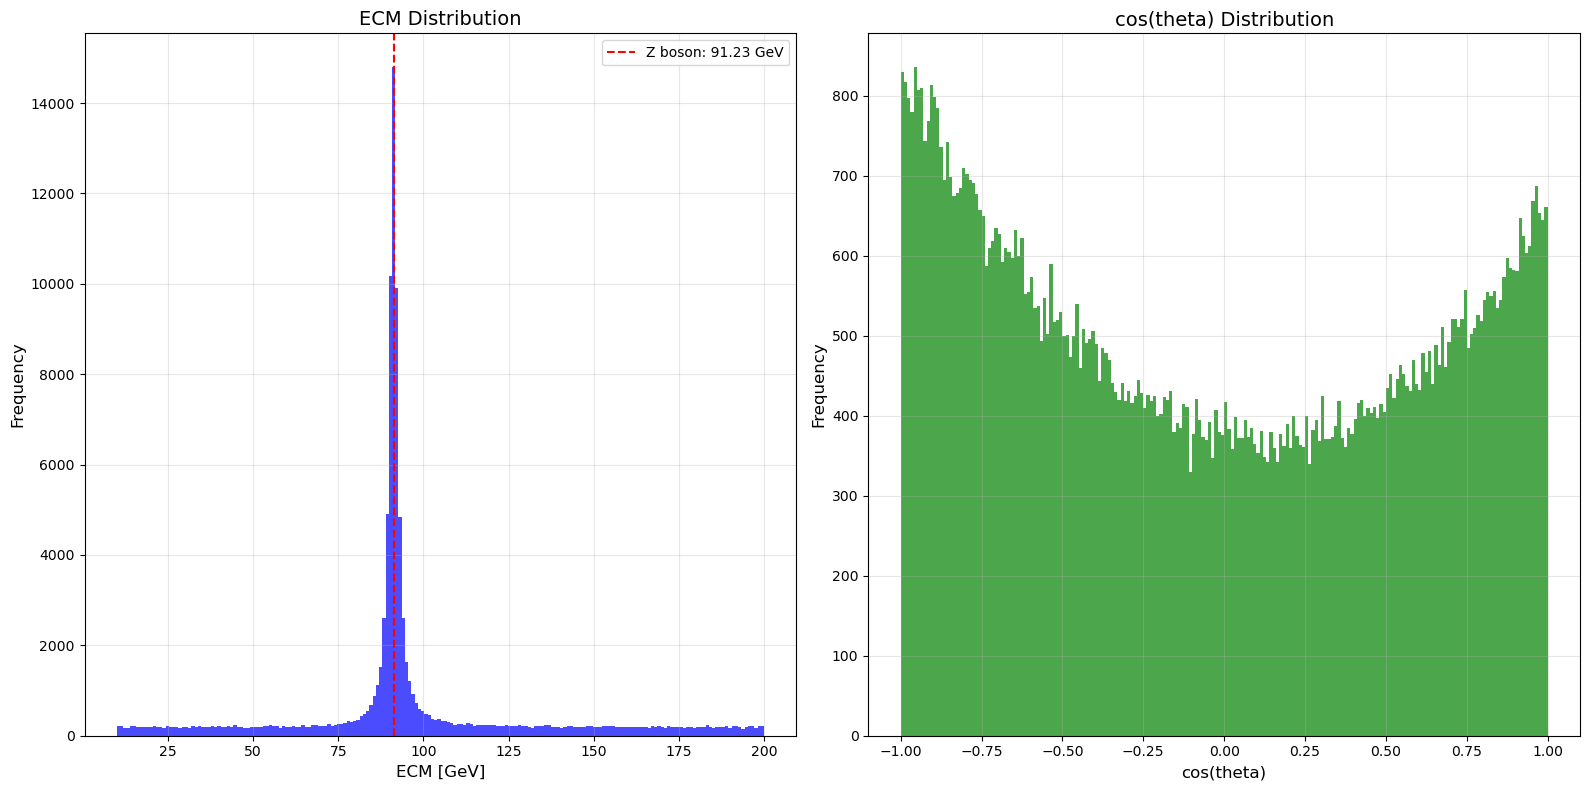

Z Boson energy: 91.228 GeV
Value of highest peak: 14804
Theoretical Z boson mass: 91.188 GeV
Difference from theoretical value: 0.040 GeV


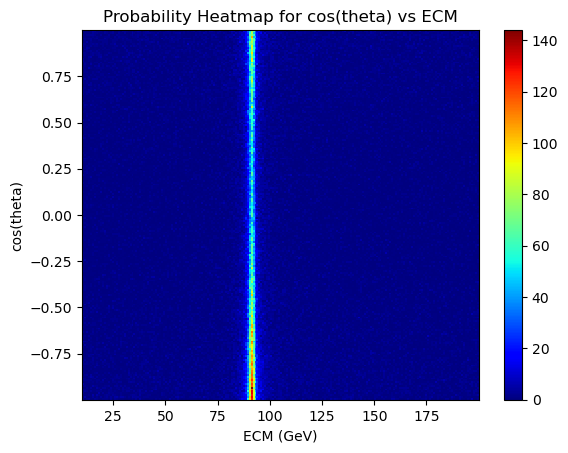

Iteration 1/10 completed. Events: 10000
Iteration 2/10 completed. Events: 20000
Iteration 3/10 completed. Events: 30000
Iteration 4/10 completed. Events: 40000
Iteration 5/10 completed. Events: 50000
Iteration 6/10 completed. Events: 60000
Iteration 7/10 completed. Events: 70000
Iteration 8/10 completed. Events: 80000
Iteration 9/10 completed. Events: 90000
Iteration 10/10 completed. Events: 100000
Generated 100000 events using the VEGAS algorithm with 10 iterations


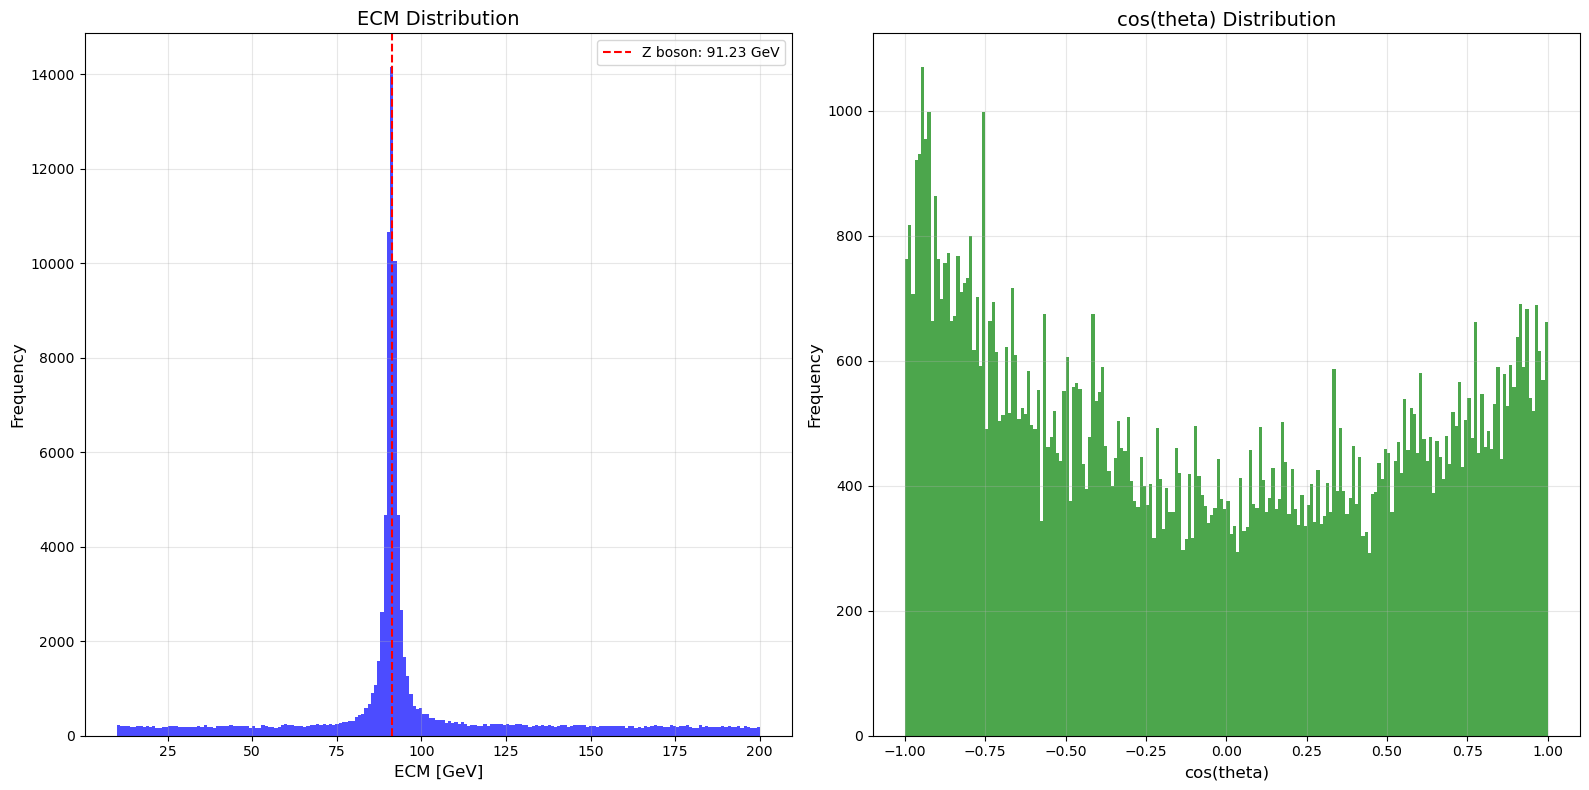

Z Boson energy: 91.225 GeV
Value of highest peak: 14160
Theoretical Z boson mass: 91.188 GeV
Difference from theoretical value: 0.037 GeV


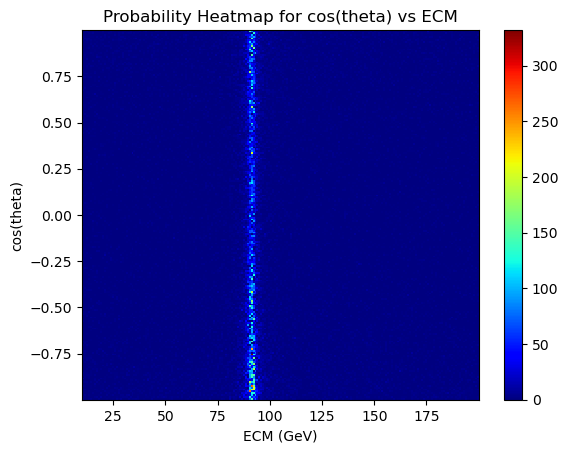

In [7]:
#running acceptance/rejection for 100,000 samples
num_samples = int(100000)  #Number of proposed samples
num_events = num_samples #fix for maxpeak
events = generate_drell_yan_events(num_samples)
print(f"Generated {num_samples} total events.")
#acceptance rate returned within g_d_y_n function
plot_distributions(events)
twodplot(events)

#visualization is the same as before, still using plot_distribution(events)
#VEGAS Parameters
num_iterations = 10  #grid adaptations
samples_per_iteration = 10000  #samples per adaptation
num_bins = 200  
alpha = 0.5  #replaced damping
num_events = 100000  #final events to generate (half of overhead)

#generate events using VEGAS
events = generate_drell_yan_events_vegas(num_events=num_events, num_iterations=num_iterations, samples_per_iteration=samples_per_iteration, num_bins=num_bins, alpha=alpha)
print(f"Generated {len(events)} events using the VEGAS algorithm with {num_iterations} iterations")
plot_distributions(events)
twodplot(events)
